In [1]:
import numpy as np                          # analisis numérico 
import pandas as pd                         # manejo de datos
import matplotlib.pyplot as plt             # Gráficos
import seaborn as sns                       # Gráficos

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from pydotplus import graph_from_dot_data
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, make_scorer


In [3]:
df = pd.read_csv("Fraudes con tarjeta de credito.csv")
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
X = df.drop('fraud', axis=1)
y = df['fraud']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
arbol = DecisionTreeClassifier()
arbol.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

Con el fin de optimizar los hiperparametros del modelo se realiza el siguiente metodo de Búsqueda en cuadrícula (Grid Search): La búsqueda en cuadrícula es una técnica que permite explorar exhaustivamente diferentes combinaciones de hiperparámetros para encontrar la configuración óptima del modelo. En el ejemplo de código que sigue, el diccionario "parametros" contiene los hiperparámetros que se van a ajustar y sus valores posibles. `GridSearchCV` realiza una validación cruzada en todas las combinaciones posibles de hiperparámetros y evalúa el rendimiento del modelo utilizando la métrica especificada

La métrica average_precision_score se utiliza comúnmente para evaluar modelos de clasificación cuando el objetivo principal es la recuperación de clases positivas. Es especialmente útil cuando tienes un conjunto de datos desequilibrado, es decir, cuando una clase es mucho más frecuente que la otra.

La precisión promedio (average precision) mide la calidad de la clasificación de una clase positiva en función de la tasa de recuperación o recall (recall). La tasa de recuperación se refiere a la proporción de instancias positivas que se identifican correctamente.

La métrica average_precision_score calcula la precisión promedio para diferentes valores de umbral de decisión y luego promedia estos valores. El umbral de decisión determina el nivel de confianza necesario para clasificar una instancia como positiva.

El cálculo de la precisión promedio implica calcular la precisión en cada punto de recuperación (cuando se recupera una instancia positiva adicional) y luego tomar el promedio de estos valores. Esto da una idea de qué tan bien se clasifican las instancias positivas en general a medida que aumenta la tasa de recuperación.

In [21]:
weights1 = {0: 1, 1: 10}
weights2 = {0: 1, 1: 100}

parametros = {'criterion': ('gini', 'entropy'),
              'max_depth': (3, 5, 7),
              'class_weight':(weights1, weights2, 'balanced')}

scorer = make_scorer(average_precision_score, needs_proba=True)

rejilla = GridSearchCV(arbol, parametros, scoring = scorer)
rejilla.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ({0: 1, 1: 10}, {0: 1, 1: 100},
                                          'balanced'),
                         'criterion': ('gini', 'entropy'),
                         'max_depth': (3, 5, 7)},
             scoring=make_scorer(average_precision_score, needs_proba=True))

In [22]:
print(rejilla.cv_results_["rank_test_score"])
print(rejilla.cv_results_["mean_test_score"])
print(rejilla.best_score_)

[16 10  3 13  8  4 18 12  6 15 11  4 16  9  1 13  7  2]
[0.94711427 0.99938697 0.99985277 0.94742471 0.99938718 0.99983848
 0.94283546 0.99713592 0.99982777 0.94712778 0.99938564 0.99983848
 0.94711427 0.99938698 0.9998944  0.94742471 0.99938718 0.99988011]
0.999894399963828


In [23]:
# Obtener los mejores hiperparámetros encontrados
best_params = rejilla.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7}


In [24]:
# Entrena el modelo con los mejores hiperparámetros encontrados
best_clf = DecisionTreeClassifier(**best_params)
best_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=7)

In [25]:
# Realiza predicciones en el conjunto de prueba
y_pred = best_clf.predict(X_test)

[Text(0.43072916666666666, 0.9375, 'x[2] <= 4.0\ngini = 0.5\nsamples = 800000\nvalue = [400000.0, 400000.0]'),
 Text(0.15833333333333333, 0.8125, 'x[0] <= 100.004\ngini = 0.334\nsamples = 717481\nvalue = [383237.083, 103116.066]'),
 Text(0.058333333333333334, 0.6875, 'x[1] <= 50.001\ngini = 0.112\nsamples = 681794\nvalue = [371321.571, 23413.379]'),
 Text(0.041666666666666664, 0.5625, 'gini = -0.0\nsamples = 671645\nvalue = [368004.493, 0.0]'),
 Text(0.075, 0.5625, 'x[6] <= 0.5\ngini = 0.217\nsamples = 10149\nvalue = [3317.079, 23413.379]'),
 Text(0.058333333333333334, 0.4375, 'gini = 0.0\nsamples = 3490\nvalue = [1912.224, 0.0]'),
 Text(0.09166666666666666, 0.4375, 'x[4] <= 0.5\ngini = 0.107\nsamples = 6659\nvalue = [1404.855, 23413.379]'),
 Text(0.03333333333333333, 0.3125, 'x[5] <= 0.5\ngini = 0.022\nsamples = 4273\nvalue = [241.083, 21915.38]'),
 Text(0.016666666666666666, 0.1875, 'gini = -0.0\nsamples = 3833\nvalue = [0.0, 21915.38]'),
 Text(0.05, 0.1875, 'x[1] <= 50.078\ngini = 0

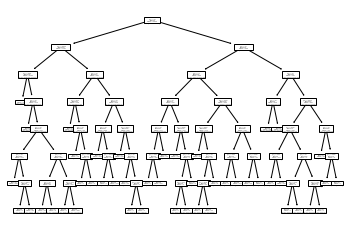

In [26]:
plot_tree(best_clf)

Profundidad del árbol: 7
Número de nodos terminales: 46


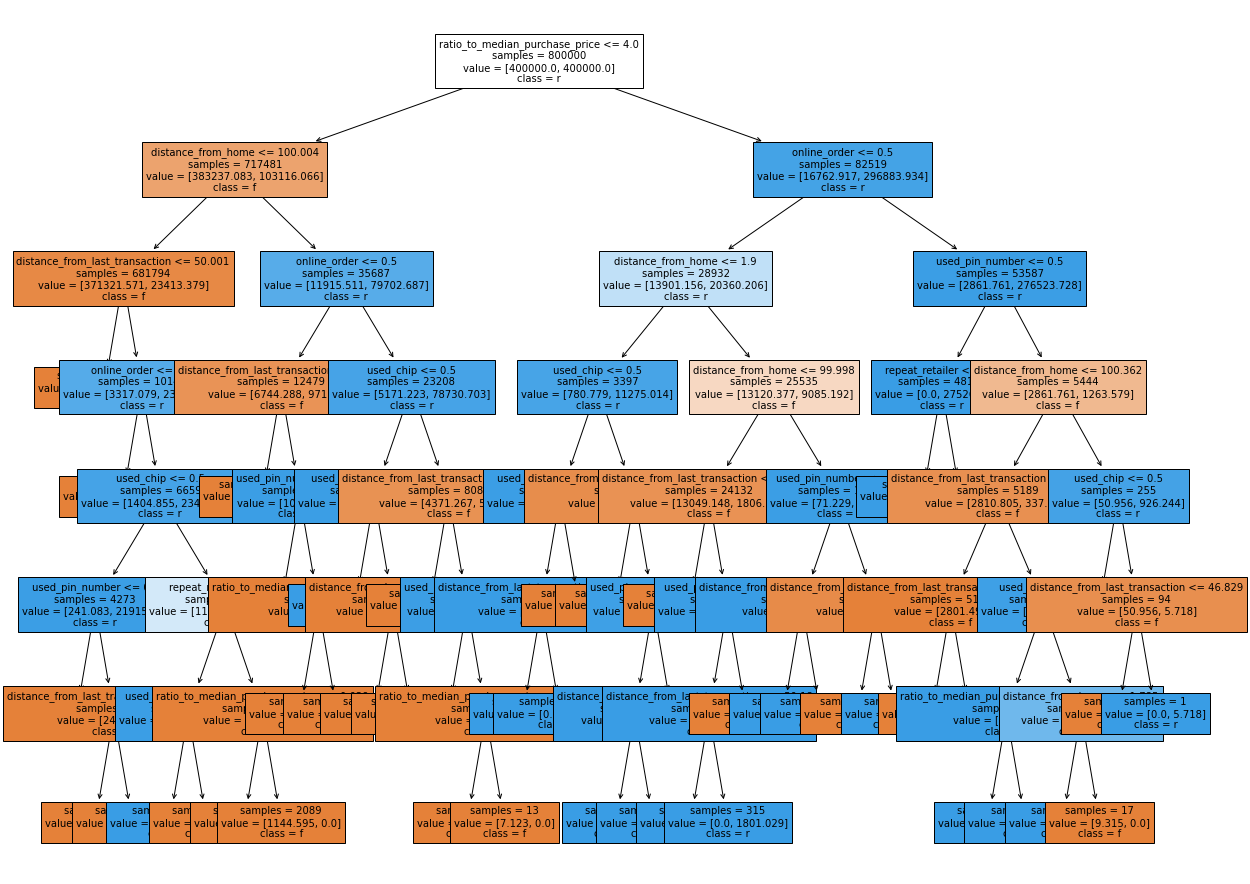

In [27]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(20, 16))

print(f"Profundidad del árbol: {best_clf.get_depth()}")
print(f"Número de nodos terminales: {best_clf.get_n_leaves()}")

plot = plot_tree(
            decision_tree = best_clf,
            feature_names = df.drop('fraud', axis=1).columns,
            class_names   = 'fraud',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 3,
            ax            = ax
       )

In [31]:
dot_data = export_graphviz(best_clf,
                         class_names = ['No-Fraude', 'Fraude'] ,
                filled = True, rounded = True,
                special_characters = True)
graph = graph_from_dot_data(dot_data)
graph.write_png('arbol_profundidad_7.png')

True

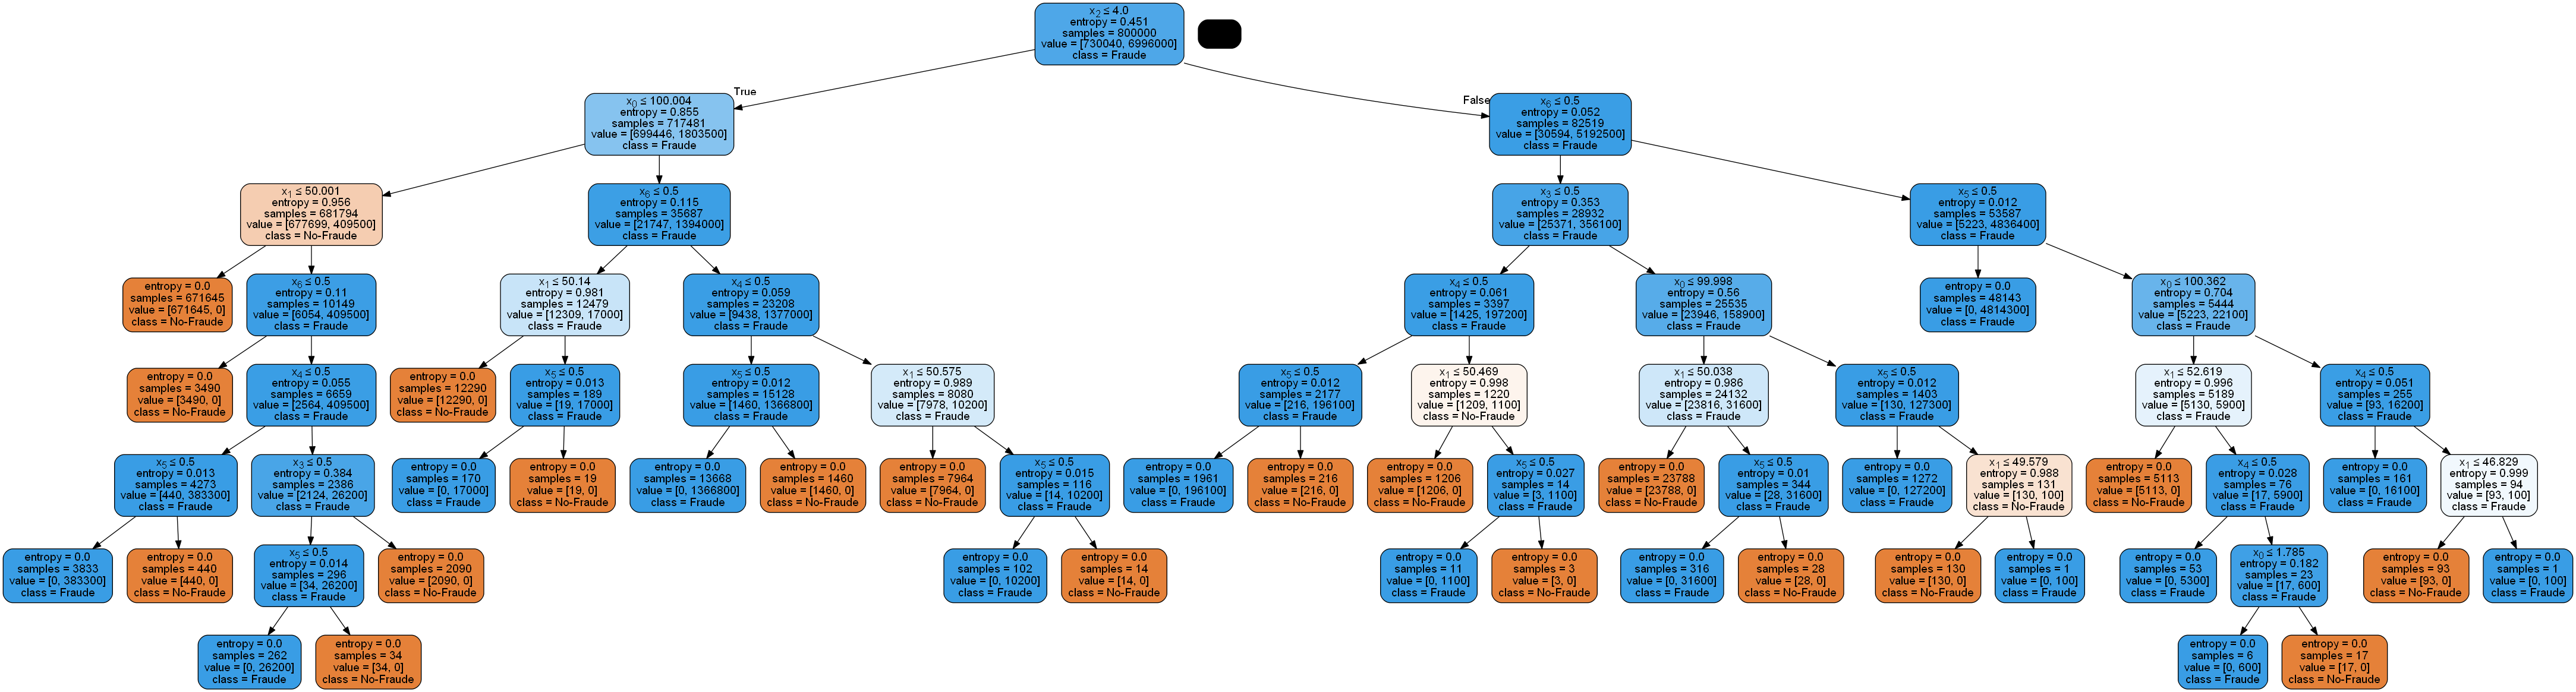

In [32]:
importances = pd.DataFrame({'Predictor':X_train.columns,'importancia':np.round(best_clf.feature_importances_,3)})
importances = importances.sort_values('importancia',ascending=False)
importances

,Predictor,importancia
2,ratio_to_median_purchase_price,0.514
0,distance_from_home,0.276
1,distance_from_last_transaction,0.112
6,online_order,0.055
4,used_chip,0.023
5,used_pin_number,0.016
3,repeat_retailer,0.003


In [28]:
# Calcula la precisión y el recall del modelo en el conjunto de prueba
precision = average_precision_score(y_test, y_pred)

print("Precisión del modelo en el conjunto de prueba:", precision)


Precisión del modelo en el conjunto de prueba: 0.9998380145234692


Matriz de Confusión:


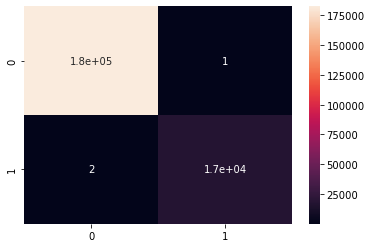

In [29]:
matriz = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')


sns.heatmap(matriz, annot=True)
plt.show()

In [30]:
# Evaluar el rendimiento utilizando métricas de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182557
         1.0       1.00      1.00      1.00     17443

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000

